In [37]:
from scipy.stats import pearsonr
from __future__ import division
import matplotlib.pyplot as plt
from nilearn import plotting
import nibabel as nib
import seaborn as sns
import pandas as pd
import numpy as np
import sys
import os

sys.path.append(os.path.join(os.environ.get("HOME"),"CNP_analysis"))
from utils.prog import log_progress as lp

%matplotlib inline

sns.set_style('white')

In [2]:
pipelines = ['fmriprep-1.0.3','fslfeat_5.0.9']

In [5]:
basedir = os.path.join(os.environ.get("PREPBASEDIR"),"fmriprep_vs_feat")

# Test - retest replicability

In [44]:
tstat = {}
thres = {}
tstatfile = {}

for pipeline in pipelines:
    tstat[pipeline] = [] # t statistics
    thres[pipeline] = [] # fwe thresholded
    tstatfile[pipeline] = []
    for sample in range(2):
        tfile = os.path.join(basedir,pipeline,'task_group/samplesize_30/experiment_0/stopsignal',
                                             'sample_%i/cope11/OLS/tstat1.nii.gz'%sample)
        tstatfile[pipeline].append(tfile)
        tstat[pipeline].append(nib.load(tfile).get_data())
        thresfile = os.path.join(basedir,pipeline,'task_group/samplesize_30/experiment_0/stopsignal',
                                             'sample_%i/cope11/OLS/thresh_vox_fwe_zstat1.nii.gz'%sample)
        thres[pipeline].append(nib.load(thresfile).get_data())

### Correlation

this can probably be improved by only looking within the mask instead of just flatten !

In [45]:
corrs = {}

for pipeline in pipelines:
    corrs[pipeline] = pearsonr(tstat[pipeline][0].flatten(),tstat[pipeline][1].flatten())

In [46]:
print(corrs)

{'fmriprep-1.0.3': (0.67267209, 0.0), 'fslfeat_5.0.9': (0.65716362, 0.0)}


### Dice

In [47]:
# binarise

def dice(pipeline):
    binarised = []
    for sample in range(2):
        flt = thres[pipeline][sample].flatten()
        binarised.append(np.array([1 if x > 0 else 0 for x in flt]))

    sm = binarised[0] + binarised[1]
    dice = np.sum(sm==2)*2/np.sum(sm>0)
    return dice

In [48]:
dices = {}
for pipeline in pipelines:
    dices[pipeline] = dice(pipeline)

In [49]:
print(dices)

{'fmriprep-1.0.3': 0.0, 'fslfeat_5.0.9': 0.0}


# Activation Count Map

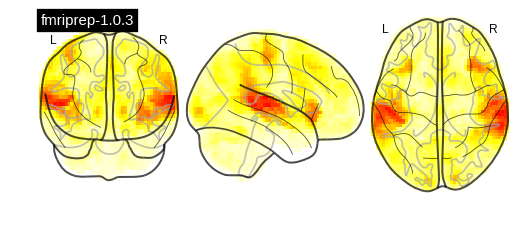

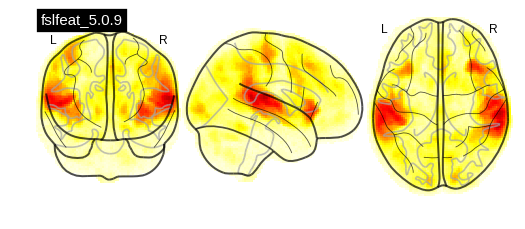

In [50]:
#cut_coords = [-15, -8, 6, 30, 46, 62]
for idx,pipeline in enumerate(pipelines):
    image = os.path.join(basedir,pipeline,"task_acm/stopsignal/zstat11_ACM_diff.nii.gz")
    plotting.plot_glass_brain(image,title=pipeline,vmin=-1,vmax=1)
plotting.show()

/share/PI/russpold/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


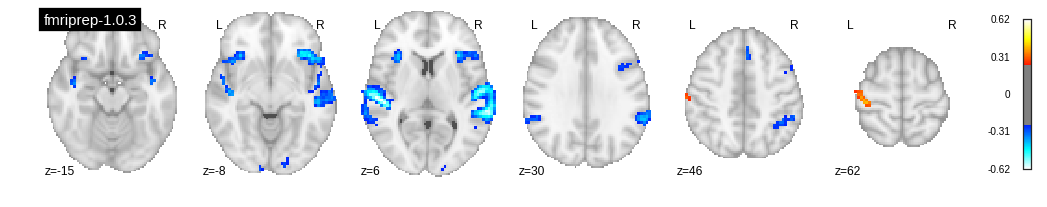

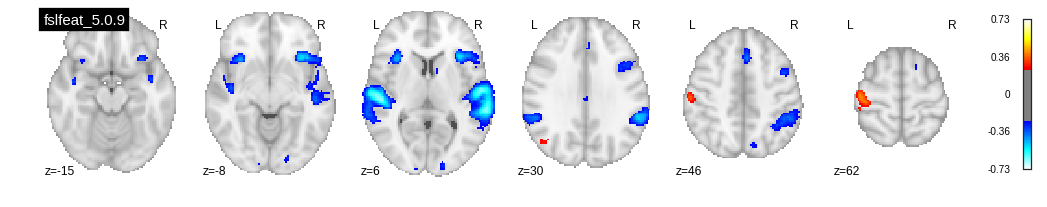

In [51]:
cut_coords = [-15, -8, 6, 30, 46, 62]
for idx,pipeline in enumerate(pipelines):
    image = os.path.join(basedir,pipeline,"task_acm/stopsignal/zstat11_ACM_diff.nii.gz")
    plotting.plot_stat_map(image,title=pipeline,threshold=0.25,display_mode='z',cut_coords=cut_coords)
plotting.show()

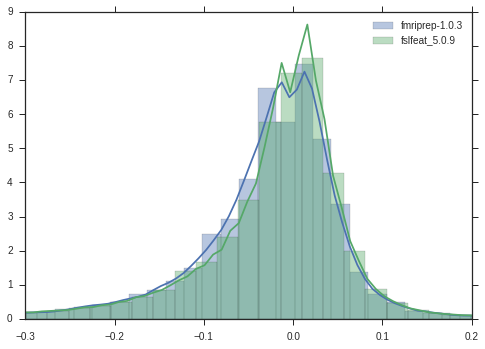

In [54]:
for idx,pipeline in enumerate(pipelines):
    image = os.path.join(basedir,pipeline,"task_acm/stopsignal/zstat11_ACM_diff.nii.gz")
    imdat = nib.load(image).get_data()
    sns.distplot(imdat[imdat != 0],label=pipeline)
plt.xlim([-0.3,0.2])
plt.legend()

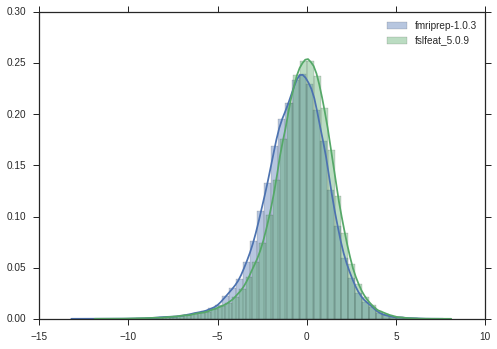

In [55]:
for pipeline in pipelines:
    ts = tstat[pipeline][0]
    sns.distplot(ts[ts!=0],label=pipeline)
    
plt.legend()

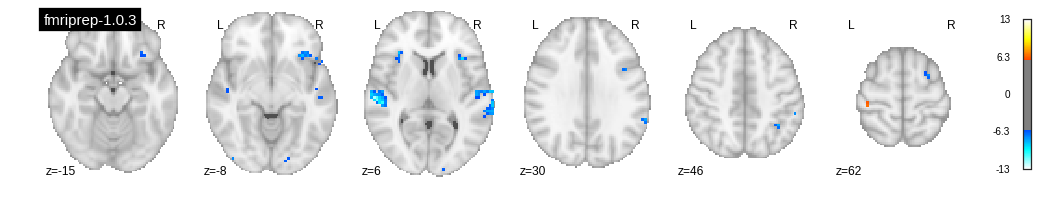

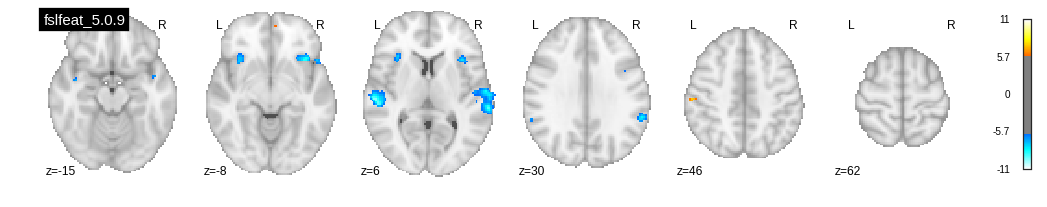

In [56]:
cut_coords = [-15, -8, 6, 30, 46, 62]
for pipeline in pipelines:
    ts = tstatfile[pipeline][0]
    plotting.plot_stat_map(ts,title=pipeline,threshold=6,display_mode='z',cut_coords=cut_coords)
plotting.show()

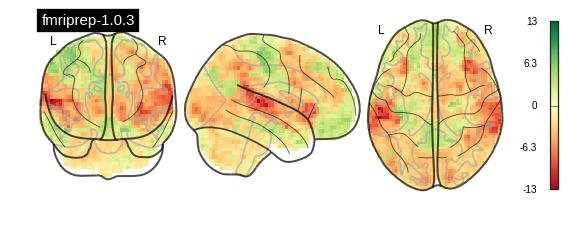

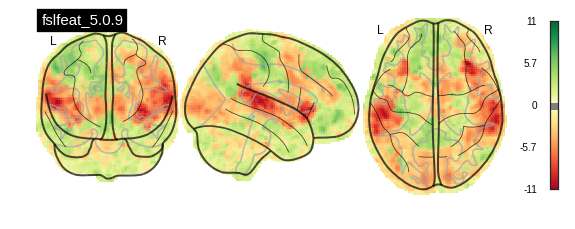

In [57]:
for pipeline in pipelines:
    ts = tstatfile[pipeline][0]
    plotting.plot_glass_brain(ts,title=pipeline,cmap='RdYlGn',colorbar=True,symmetric_cbar=True,plot_abs=False)
plotting.show()

In [38]:
results = {"samplesize":[],"experiment":[],"pipeline":[]}
results = pd.DataFrame(results)
for pipeline in pipelines:
    for samplesize in lp(range(10,31)):
        for experiment in range(50):
#             pipeline = pipelines[0]
#             experiment=0
#             samplesize = 10
            tvals = {}
            for sample in range(2):
                tfile = os.path.join(basedir,pipeline,'task_group/samplesize_%i/experiment_%i/stopsignal'%(samplesize,experiment),
                                                         'sample_%i/cope11/OLS/tstat1.nii.gz'%(sample))
                tvals[sample] = nib.load(tfile).get_data()

            tmpmask = np.where(np.logical_and(tvals[0]!=0,tvals[1]!=0))
            cor = pearsonr(tvals[0][tmpmask],tvals[1][tmpmask])[0]
            res = {"samplesize":samplesize,"pipeline":pipeline,"experiment":experiment,"correlation":cor}
            results = results.append(res,ignore_index=True)

In [40]:
results.head()

,experiment,pipeline,samplesize,correlation
0,0,fmriprep-1.0.3,10,0.435008
1,1,fmriprep-1.0.3,10,0.418858
2,2,fmriprep-1.0.3,10,0.364057
3,3,fmriprep-1.0.3,10,0.472500
4,4,fmriprep-1.0.3,10,0.392212


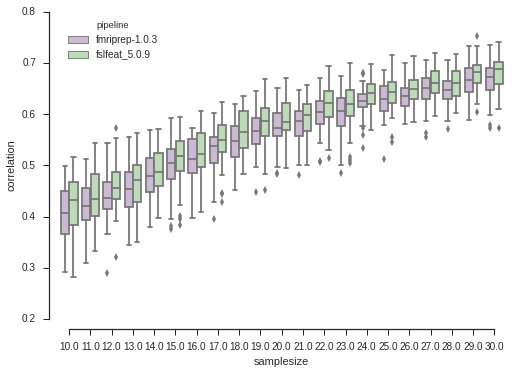

In [41]:
sns.set(style="ticks")
sns.boxplot(x="samplesize", y="correlation", hue="pipeline", data=results, palette="PRGn")
sns.despine(offset=10, trim=True)